<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Transfer_Learning_for_Image_clf(Homer_and_Bart).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras.models import Model  # for model creation functional API

#Global avg pooling is similar to flatten(), but here if shape is 8 , 8 , 2048 result is 2048 rather than 8 * 8 * 2048
# makes things simpler
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,\
 Dropout 



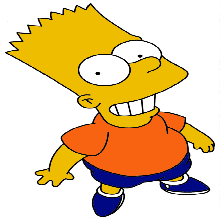

In [3]:
# extract image

path = "/content/drive/MyDrive/Computer Vision Masterclass Files/Datasets/homer_bart_2.zip"

zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall("./")
zip_object.close()

keras.preprocessing.image.load_img("/content/homer_bart_2/training_set/bart/bart115.bmp", target_size = (220, 220))

### Train and Test set

In [4]:
# preprocess image and also generate more images using data augmentation
training_generator = ImageDataGenerator(
    rescale = 1./255, # normalize data 
    rotation_range = 7,
    horizontal_flip = True,
    zoom_range = 0.2
)

In [5]:
train_dataset = training_generator.flow_from_directory("/content/homer_bart_2/training_set",
                                                       target_size = (256, 256),  # same as shape needed by the pretrained model input
                                                       batch_size = 8,
                                                       class_mode = "categorical",
                                                       shuffle =True
                                                       )

Found 215 images belonging to 2 classes.


In [6]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [7]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [8]:
# when creating test gen, no need to apply dataAug since we are testing the cnn on this
test_generator = ImageDataGenerator(rescale = 1./255)  

test_dataset = test_generator.flow_from_directory("/content/homer_bart_2/test_set",
                                                       target_size = (256, 256),
                                                       batch_size = 1,              # batch size for test should be 1
                                                       class_mode = "categorical",  
                                                       shuffle = False              # needed for test, so we can compare with associated output(test_data)
                                                       )

Found 54 images belonging to 2 classes.


### Build and Train The Model

In [9]:
# ResNet
base_model = keras.applications.ResNet50(weights = "imagenet", include_top = False, 
                                         input_tensor = Input(shape = (256, 256, 3)),  # optional stuff                                    
                                         )

base_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [10]:
len(base_model.layers)  # num of layers in base_model

175

In [11]:
# freeze layers to avoid training base_model layers in training
for layer in base_model.layers:
  layer.trainable = False

In [12]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [13]:
# model head(Dense part)
head_model = base_model.output

# functional api
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation ="relu")(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(units = 1025, activation ="relu")(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation ="softmax")(head_model)

In [14]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [15]:
network = Model(inputs = base_model.inputs, outputs = head_model)

len(network.layers)

181

In [16]:
network.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [17]:
history = network.fit(train_dataset, validation_data = test_dataset, epochs = 50)

Epoch 1/50
27/27 [==============================] - 19s 208ms/step - loss: 1.4119 - accuracy: 0.5535 - val_loss: 0.8370 - val_accuracy: 0.5185
Epoch 2/50
27/27 [==============================] - 4s 150ms/step - loss: 0.6913 - accuracy: 0.5814 - val_loss: 0.6508 - val_accuracy: 0.6481
Epoch 3/50
27/27 [==============================] - 4s 149ms/step - loss: 0.6740 - accuracy: 0.6000 - val_loss: 0.6220 - val_accuracy: 0.6481
Epoch 4/50
27/27 [==============================] - 4s 150ms/step - loss: 0.6486 - accuracy: 0.6093 - val_loss: 0.5980 - val_accuracy: 0.7407
Epoch 5/50
27/27 [==============================] - 4s 147ms/step - loss: 0.6204 - accuracy: 0.6651 - val_loss: 0.5977 - val_accuracy: 0.6481
Epoch 6/50
27/27 [==============================] - 4s 149ms/step - loss: 0.6259 - accuracy: 0.6419 - val_loss: 0.5550 - val_accuracy: 0.7593
Epoch 7/50
27/27 [==============================] - 4s 149ms/step - loss: 0.6199 - accuracy: 0.6744 - val_loss: 0.6372 - val_accuracy: 0.6111
Epoch

### Model evaluation

In [18]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [19]:
predictions = np.argmax(network.predict(test_dataset), axis = 1)

predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1])

In [20]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Model accuracy: 0.8148148148148148
Model precision: 0.8333333333333334
Model recall: 0.7692307692307693
Model f1_score: 0.8


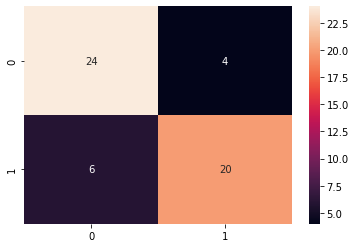

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            confusion_matrix, classification_report

y_test = test_dataset.classes

print(f"Model accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model precision: {precision_score(y_test, predictions)}")
print(f"Model recall: {recall_score(y_test, predictions)}")
print(f"Model f1_score: {f1_score(y_test, predictions)}")


sns.heatmap(confusion_matrix(y_test, predictions), annot =True);


#### Fine Tunning

* Used when dataset is Large amd similar to base_model's trained input
* datset set is smaller and different from base model's train input(matches our criteria) remember to use smaller learning rate to avoid overfitting

In [23]:
# unfreeze the base_model layers
base_model.trainable = True

In [31]:
fine_tuning_at = 150   # meaning layers from 0 to this will be freezed

for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False


In [32]:
network.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [33]:
history = network.fit(train_dataset, validation_data = test_dataset, epochs = 50)

Epoch 1/50
27/27 [==============================] - 8s 186ms/step - loss: 0.1787 - accuracy: 0.9256 - val_loss: 2.1536 - val_accuracy: 0.7963
Epoch 2/50
27/27 [==============================] - 4s 152ms/step - loss: 0.3325 - accuracy: 0.8837 - val_loss: 6.8491 - val_accuracy: 0.5185
Epoch 3/50
27/27 [==============================] - 4s 150ms/step - loss: 0.0605 - accuracy: 0.9767 - val_loss: 4.0642 - val_accuracy: 0.8704
Epoch 4/50
27/27 [==============================] - 4s 152ms/step - loss: 0.1937 - accuracy: 0.9442 - val_loss: 22.5694 - val_accuracy: 0.6111
Epoch 5/50
27/27 [==============================] - 4s 150ms/step - loss: 0.1809 - accuracy: 0.9349 - val_loss: 1.5739 - val_accuracy: 0.9259
Epoch 6/50
27/27 [==============================] - 4s 153ms/step - loss: 0.2643 - accuracy: 0.9395 - val_loss: 2.8162 - val_accuracy: 0.8889
Epoch 7/50
27/27 [==============================] - 4s 153ms/step - loss: 0.1616 - accuracy: 0.9349 - val_loss: 0.7021 - val_accuracy: 0.9259
Epoch

### Model evaluation

In [34]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [35]:
predictions = np.argmax(network.predict(test_dataset), axis = 1)

predictions

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Model accuracy: 0.8703703703703703
Model precision: 0.8064516129032258
Model recall: 0.9615384615384616
Model f1_score: 0.8771929824561403


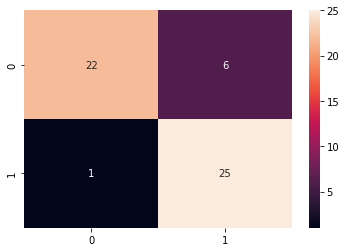

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            confusion_matrix, classification_report

y_test = test_dataset.classes

print(f"Model accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model precision: {precision_score(y_test, predictions)}")
print(f"Model recall: {recall_score(y_test, predictions)}")
print(f"Model f1_score: {f1_score(y_test, predictions)}")


sns.heatmap(confusion_matrix(y_test, predictions), annot =True);


### Saving and Loading Model

In [38]:
model_json = network.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)


In [39]:
from keras.models import save_model
model_saved = save_model(network, "/content/weights.hdf5")

In [40]:
# Load the model
with open("model.json", "r") as json_file:
  json_saved_model = json_file.read()

json_saved_model


network_loaded = keras.models.model_from_json(json_saved_model)
network_loaded.load_weights("weights.hdf5")
network_loaded.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

#### clf a single image

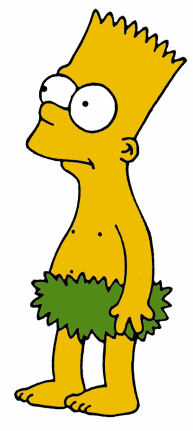

In [54]:
image = cv2.imread("/content/homer_bart_2/test_set/bart/bart20.bmp")
cv2_imshow(image)

In [55]:
image.shape

(431, 193, 3)

In [56]:
# reshape image to input shape of CNN
image = cv2.resize(image, (256, 256))

print(image.shape)

print(f"image max number an min are: {image.max()}, {image.min()}")

(256, 256, 3)
image max number an min are: 254, 0


In [57]:
# scale the image
image = image / 255.
print(f"image max number an min are: {image.max()}, {image.min()}")

image max number an min are: 0.996078431372549, 0.0


In [58]:
# add new dim to denote batch size for image training
image = image.reshape(-1, 256, 256, 3)
image.shape

(1, 256, 256, 3)

In [59]:
result = np.argmax(network_loaded.predict(image))

if(result == 0):
  print("bart")
else:
  print("Homer")

bart
